# Построение ML-продукта для выявления и оптимизации платежей преподавателей сервиса Repetit.ru. Описание проекта.


Сервис передает контакты клиента (ученика) репетитору. Если репетитор начинает заниматься с
учеником, то он должен платить сервису комиссию от каждого занятия. Но в реальности так происходит
не всегда. Иногда, это из-за того, что репетитор звонит по телефону и ему просто не отвечают.
Некоторые репетиторы плохо договариваются о занятиях или обманывают. Сервис теряет деньги каждый
раз, когда отдаёт заявку неэффективному репетитору. Заказчику нужно как можно раньше понять, что
репетитор недобросовестный или мошенник, чтобы отключить его от сервиса и отдавать заявки
ответственным репетиторам.
Сейчас эта задача решается ручным просмотром сотрудниками или никак.




**Задачи:**
Разработать модель, которая по имеющейся информации о репетиторе и проведенных им занятиях будет
классифицировать репетиторов как платящих или неэффективных. Оценка качества модели будет
производиться с использованием метрики F1.

# Загрузка данных и знакомство с ними.

Подключаем гугл диск, на котором у меня лежат данные.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загружаем библиотеки, которые потребуются нам для выполнения проекта.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    KFold,
    train_test_split
)

from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

!pip install pycaret
from pycaret.classification import *

Фиксируем переменную для Random State будущих моделей машинного обучения.

In [ ]:
RNDM_STATE = 42

Создаём функции.

In [ ]:
# Функция для исследования датафреймов.


def df_info(df):
    print(df.info())
    print('')
    display(df.sample(10))
    print('')
    display(df.describe())
    print('')
    print(f'Количество явных дубликатов в датафрейме: {df.duplicated().sum()}.')
    print('')
    print('Процент пропусков по столбцам:')
    display(
        pd.DataFrame(round(df.isna().mean() * 100, 2)).style.background_gradient(
            'coolwarm'
        )
    )


def train_test_models(df, target_column):
    # Разделение на признаки и целевую переменную
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Стандартизация численных признаков
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    X[numeric_features] = scaler.fit_transform(X[numeric_features])

    # Разделение на тренировочную и тестовую выборки с учётом дисбаланса классов
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RNDM_STATE, stratify=y
    )
    smote = SMOTE(sampling_strategy='auto',  random_state=RNDM_STATE)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Инициализация моделей
    nb_model = GaussianNB()
    lr_model = LogisticRegression(random_state=RNDM_STATE)
    dt_model = DecisionTreeClassifier(random_state=RNDM_STATE)
    rf_model = RandomForestClassifier(random_state=RNDM_STATE)

    # Расчёт показателя метрики f1 при помощи кроссвалидации
    f1_scorer = make_scorer(f1_score)
    nb_f1 = cross_val_score(
        nb_model, X_train_resampled, y_train_resampled, cv=5, scoring='f1'
    ).mean()
    lr_f1 = cross_val_score(
        lr_model, X_train_resampled, y_train_resampled, cv=5, scoring=f1_scorer
    ).mean()
    dt_f1 = cross_val_score(
        dt_model, X_train_resampled, y_train_resampled, cv=5, scoring='f1'
    ).mean()
    rf_f1 = cross_val_score(
        rf_model, X_train_resampled, y_train_resampled, cv=5, scoring=f1_scorer
    ).mean()

    # Возврат результатов.
    return {
        'Наивный байесовский классификатор': nb_f1,
        'Логистическая регрессия': lr_f1,
        'Решающее дерево': dt_f1,
        'Random Forest': rf_f1,
    }

In [ ]:
df_teachers = pd.read_feather(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Repetit_ru/teachers.feather'
)
df_teachers_info = pd.read_feather(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Repetit_ru/teachers_info.feather'
)
df_teachers_prices = pd.read_feather(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Repetit_ru/teacher_prices.feather'
)
df_lessons = pd.read_feather(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Repetit_ru/lessons.feather'
)
df_lessons_course = pd.read_feather(
    '//content/drive/MyDrive/Colab Notebooks/Datasets/Repetit_ru/lesson_course.feather'
)
df_orders = pd.read_feather(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Repetit_ru/orders.feather'
)

Смотрим информацию о данных.

In [ ]:
df_info(df_teachers_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307972 non-null  int64  
 1   reg_date                 307972 non-null  object 
 2   birth_date               307972 non-null  object 
 3   teaching_start_date      307972 non-null  object 
 4   is_email_confirmed       307972 non-null  int64  
 5   lesson_duration          307972 non-null  int64  
 6   lesson_cost              307972 non-null  int64  
 7   is_display               307972 non-null  int64  
 8   last_visited             235837 non-null  object 
 9   is_pupils_needed         11208 non-null   float64
 10  is_cell_phone_confirmed  307972 non-null  int64  
 11  area_id                  307972 non-null  int64  
 12  sex                      307972 non-null  int64  
 13  orders_allowed           307972 non-null  int64  
 14  revi

,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
85147,87591,2015-06-29 18:06:24.000,1993-07-23 00:00:00.000,2009-09-01 00:00:00.000,0,60,10,0,None,NaN,0,2,2,1,0
37080,38394,2012-04-09 13:47:10.000,1989-09-28 00:00:00.000,2008-01-01 00:00:00.000,0,60,500,0,2012-05-19 20:47:24.000,NaN,0,1,2,1,0
69641,71613,2014-09-13 00:49:58.000,1967-09-28 00:00:00.000,1986-09-01 00:00:00.000,0,60,1250,1,2019-09-12 11:06:46.370,NaN,0,2,2,1,6
49735,51193,2013-04-01 15:46:54.000,1987-09-19 00:00:00.000,2007-09-01 00:00:00.000,0,60,400,1,2016-12-29 11:44:54.000,NaN,0,20,2,0,0
260648,265268,2022-07-16 10:25:12.173,1966-10-27 00:00:00.000,2012-09-01 00:00:00.000,0,60,0,1,2022-07-16 14:41:08.310,NaN,0,2,2,1,0
202987,207398,2020-08-19 12:00:06.610,1996-10-10 00:00:00.000,2018-09-01 00:00:00.000,0,60,0,0,2020-08-19 14:33:59.437,NaN,0,1,2,1,0
54435,56069,2013-09-04 23:30:32.000,1993-03-10 00:00:00.000,2012-09-01 00:00:00.000,0,45,800,0,2021-03-23 16:13:52.757,NaN,0,2,2,1,1
262052,266672,2022-08-02 14:16:03.913,1969-12-22 00:00:00.000,1991-09-01 00:00:00.000,0,60,2000,1,2022-08-25 07:36:20.880,NaN,0,1,2,1,0
265235,269855,2022-08-29 11:42:49.793,1998-05-06 00:00:00.000,2017-09-01 00:00:00.000,0,60,800,1,2022-09-04 19:53:04.587,NaN,0,1,2,1,0
197030,201439,2020-05-26 20:31:01.593,1972-01-07 00:00:00.000,1990-09-01 00:00:00.000,0,60,0,1,2020-07-08 13:59:43.153,NaN,0,1,2,1,0


,id,is_email_confirmed,lesson_duration,lesson_cost,is_display,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
count,307972.000000,307972.000000,307972.000000,3.079720e+05,307972.000000,11208.000000,307972.000000,307972.000000,307972.000000,307972.000000,307972.000000
mean,157246.177036,0.012732,61.502978,5.325806e+02,0.658735,0.948162,0.006910,8.488928,1.776892,0.860702,1.087859
std,90198.005463,0.112114,15.061675,2.146357e+03,0.474135,0.221710,0.082837,16.442877,0.467861,0.346258,4.863274
min,33.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,79390.750000,0.000000,60.000000,0.000000e+00,0.000000,1.000000,0.000000,1.000000,2.000000,1.000000,0.000000
50%,157384.500000,0.000000,60.000000,5.000000e+02,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,0.000000
75%,235434.250000,0.000000,60.000000,9.000000e+02,1.000000,1.000000,0.000000,6.000000,2.000000,1.000000,0.000000
max,312622.000000,1.000000,999.000000,1.021709e+06,1.000000,1.000000,1.000000,121.000000,3.000000,1.000000,381.000000



Количество явных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
id,0.000000
reg_date,0.000000
birth_date,0.000000
teaching_start_date,0.000000
is_email_confirmed,0.000000
lesson_duration,0.000000
lesson_cost,0.000000
is_display,0.000000
last_visited,23.420000
is_pupils_needed,96.360000


**Информация о репетиторах**

- id - айди репетитора
- reg_date - дата регистрации
- birth_date - дата рождения
- teaching_start_date - дата начала первого занятия
- is_email_confirmed - подтвержден ли e-mail адресс
- lesson_duration - продолжит урока
- lesson_cost - стоимость урока
- is_display - показывается в каталоге
- last_visited - послеждний визит
- is_pupils_needed - открыт для заявок
- is_cell_phone_confirmed - подтвержден ли номер телефона
- area_id - регион
- sex - пол
- orders_allowed - разрешено назначать на заявки
- review_num - отзывы

Загружаем данные.

In [ ]:
df_info(df_teachers)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 103.6 KB
None



,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
650,40669,264.0,1908.565737,251.0,0.142857,9.296296,479050.0,0
856,120480,346.0,1543.644068,118.0,0.209877,6.941176,182150.0,1
555,296829,365.0,611.340206,97.0,0.087379,10.777778,59300.0,1
621,171741,426.0,974.786325,117.0,0.144578,9.750000,114050.0,1
563,56129,1235.0,2510.978044,501.0,0.382114,10.659574,1258000.0,0
936,221579,116.0,1351.485149,101.0,0.114094,5.941176,136500.0,0
231,73833,973.0,2358.230088,565.0,0.240000,18.833333,1332400.0,0
733,160467,8.0,1000.000000,8.0,0.076923,8.000000,8000.0,0
652,140306,102.0,1500.000000,101.0,0.114583,9.181818,151500.0,0
232,5813,426.0,2930.468750,320.0,0.246377,18.823529,937750.0,0


,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
count,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1.656000e+03,1656.000000
mean,195700.558575,177.651570,1509.636125,104.064614,0.194887,9.872112,1.750237e+05,0.336353
std,87667.530193,336.451272,908.722960,217.635955,0.135023,9.601426,4.850086e+05,0.472604
min,458.000000,1.000000,200.000000,1.000000,0.009901,1.000000,2.000000e+02,0.000000
25%,130185.500000,12.000000,994.880952,8.000000,0.105263,3.000000,9.000000e+03,0.000000
50%,210036.500000,54.000000,1350.308642,30.000000,0.166667,7.094017,4.310000e+04,0.000000
75%,276014.500000,207.500000,1852.012502,103.000000,0.250000,13.500000,1.483500e+05,1.000000
max,317531.000000,5690.000000,15000.000000,3788.000000,1.000000,78.166667,1.116220e+07,1.000000



Количество явных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
id,0.000000
lessons_delivered,0.000000
mean_lesson_price,0.000000
lessons_given,0.000000
lessons_started_fraction,0.000000
lessons_per_pupil,0.000000
money_recieved,0.000000
blocked,0.000000


**Статистика по репетиторам и таргет**

- id - айди репетитора
- lessons_delivered - поставлено уроков
- mean_lesson_price - средняя стоимость уроков
- lessons_given - оплачено уроков
- lessons_started_fraction - процент начала занятий
- lessons_per_pupil - занятий на ученика
- money_recieved - получено денег
- blocked - целевой признак (active/blocked)

In [ ]:
df_info(df_lessons_course)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893438 entries, 0 to 893437
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 893438 non-null  int64  
 1   client_id          893437 non-null  float64
 2   teacher_id         893438 non-null  int64  
 3   order_id           890132 non-null  float64
 4   lesson_place       893438 non-null  int64  
 5   lesson_price       893438 non-null  int64  
 6   is_active          893438 non-null  int64  
 7   lesson_duration    893438 non-null  int64  
 8   date_updated       893438 non-null  object 
 9   suspend_till_date  893438 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 68.2+ MB
None



,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
640408,1312446,1163898.0,191656,2652018.0,2,1500,0,60,2023-06-28 21:15:13.663,1800-01-01 00:00:00.000
318033,1048805,529365.0,261911,2211760.0,4,1000,1,60,2022-09-27 11:37:38.070,1800-01-01 00:00:00.000
406781,838598,796168.0,80450,1823940.0,6,2000,0,90,2021-10-16 16:11:01.823,1800-01-01 00:00:00.000
484105,1067570,1007362.0,46510,2246664.0,4,1000,0,60,2022-10-09 09:18:54.403,1800-01-01 00:00:00.000
576128,863456,873670.0,228234,1867777.0,1,1000,0,60,2021-12-08 01:59:44.430,1800-01-01 00:00:00.000
448499,931458,895203.0,217956,1996602.0,4,1000,0,60,2022-03-10 16:29:40.257,1800-01-01 00:00:00.000
402685,1133990,1054160.0,196268,2377887.0,4,1500,0,60,2022-12-17 22:03:37.323,1800-01-01 00:00:00.000
565603,1298526,425451.0,4297,2632480.0,4,2500,0,60,2023-06-10 18:25:00.723,1800-01-01 00:00:00.000
655365,1320414,721488.0,247013,2663290.0,2,1500,0,60,2023-07-09 15:01:35.033,1800-01-01 00:00:00.000
200105,964950,941357.0,217508,2059075.0,4,1000,0,60,2022-05-16 17:37:13.790,1800-01-01 00:00:00.000


,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration
count,8.934380e+05,8.934370e+05,893438.000000,8.901320e+05,893438.000000,8.934380e+05,893438.000000,8.934380e+05
mean,1.052919e+06,9.104992e+05,156999.072977,2.201949e+06,3.399830,1.284200e+03,0.222249,-4.737214e+03
std,2.599766e+05,2.360247e+05,79431.722496,4.524514e+05,1.554386,3.624318e+03,0.415758,3.213024e+06
min,1.000000e+01,1.000000e+00,33.000000,1.100000e+01,0.000000,0.000000e+00,0.000000,-2.147484e+09
25%,8.303462e+05,7.685850e+05,95659.000000,1.808246e+06,2.000000,7.000000e+02,0.000000,6.000000e+01
50%,1.053760e+06,9.266170e+05,160006.000000,2.219964e+06,4.000000,1.000000e+03,0.000000,6.000000e+01
75%,1.277182e+06,1.107521e+06,220809.000000,2.602854e+06,4.000000,1.500000e+03,0.000000,6.000000e+01
max,1.505419e+06,1.268616e+06,312244.000000,2.936670e+06,7.000000,2.500000e+06,1.000000,8.032022e+06



Количество явных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
id,0.000000
client_id,0.000000
teacher_id,0.000000
order_id,0.370000
lesson_place,0.000000
lesson_price,0.000000
is_active,0.000000
lesson_duration,0.000000
date_updated,0.000000
suspend_till_date,0.000000


**Ученики**

- Id - айди
- client_id - айди ученика
- teacher_id - айди репетитора
- order_id - айди заявки
- lesson_place - занятия онлайн или офлайн
- lesson_price - цена
- is_active - идут ли занятия, на паузе, завершены
- lesson_duration - продолжительность урока
- date_updated
- suspend_till_date

In [ ]:
df_info(df_lessons)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   id                1191127 non-null  int32   
 1   lesson_course_id  1191127 non-null  int32   
 2   lesson_date       1191127 non-null  category
 3   time_from         1191127 non-null  category
 4   time_to           1191127 non-null  category
 5   home_task         4969 non-null     category
 6   is_regular        1191127 non-null  int8    
 7   amount_to_pay     593376 non-null   float64 
 8   amount_paid       8143 non-null     float64 
dtypes: category(4), float64(2), int32(2), int8(1)
memory usage: 37.9 MB
None



,id,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
1007676,3860039,1306175,2023-10-12 00:00:00.000,18:00:00,19:00:00,NaN,0,700.0,NaN
958791,3712655,1315875,2023-07-07 00:00:00.000,20:00:00,20:45:00,NaN,0,1000.0,NaN
355701,2362153,871309,2022-03-26 00:00:00.000,13:10:00,14:10:00,NaN,1,NaN,NaN
134631,1918741,803080,2021-10-19 00:00:00.000,19:00:00,20:00:00,NaN,0,NaN,NaN
42394,1746408,703136,2021-11-17 00:00:00.000,10:00:00,11:00:00,NaN,0,NaN,NaN
192123,2025019,854168,2021-11-17 00:00:00.000,20:00:00,21:00:00,NaN,0,60.0,NaN
598624,2898402,1065165,2022-10-08 00:00:00.000,14:00:00,15:00:00,NaN,0,NaN,NaN
753864,3207184,1128592,2023-10-27 00:00:00.000,17:00:00,18:30:00,NaN,0,NaN,NaN
302523,2247517,338397,2022-06-15 00:00:00.000,15:00:00,16:00:00,NaN,0,NaN,NaN
997723,3819429,1018311,2023-10-24 00:00:00.000,17:00:00,18:00:00,NaN,1,1500.0,NaN


,id,lesson_course_id,is_regular,amount_to_pay,amount_paid
count,1.191127e+06,1.191127e+06,1.191127e+06,5.933760e+05,8143.000000
mean,2.924256e+06,9.922974e+05,1.695839e-01,1.183844e+03,1817.346801
std,7.860067e+05,2.711573e+05,3.752670e-01,4.684526e+03,972.736517
min,1.357970e+05,3.000000e+00,0.000000e+00,0.000000e+00,200.000000
25%,2.238784e+06,8.177580e+05,0.000000e+00,7.000000e+02,1100.000000
50%,2.891741e+06,9.833430e+05,0.000000e+00,1.000000e+03,1500.000000
75%,3.546280e+06,1.157515e+06,0.000000e+00,1.500000e+03,2000.000000
max,4.516941e+06,1.610713e+06,1.000000e+00,2.500000e+06,24000.000000



Количество явных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
id,0.000000
lesson_course_id,0.000000
lesson_date,0.000000
time_from,0.000000
time_to,0.000000
home_task,99.580000
is_regular,0.000000
amount_to_pay,50.180000
amount_paid,99.320000


**Занятия**

- Id - айди
- lesson_course_id - айди ученика
- lesson_date - дата
- time_from - время от
- time_to - время до
- home_task - дз
- is_regular - автоматически повторяющееся занятие
- amount_to_pay - стоимость
- amount_paid - оплачено

In [ ]:
df_info(df_teachers_prices)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432422 entries, 0 to 432421
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     432422 non-null  object 
 1   teacher_id      427852 non-null  float64
 2   subject_id      432422 non-null  int64  
 3   price           432422 non-null  int64  
 4   price_external  432422 non-null  int64  
 5   price_remote    432422 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB
None



,date_update,teacher_id,subject_id,price,price_external,price_remote
114154,2014-10-27 14:00:30.833,76131.0,2,800,800,500
265429,2019-10-14 19:25:13.447,181755.0,20,600,0,0
129951,2015-05-20 15:18:23.160,86590.0,21,0,250,250
185975,2017-07-25 18:43:48.393,88631.0,1,0,1700,0
298309,2020-08-13 15:16:24.090,206641.0,8,1500,1500,1000
221232,2018-09-06 11:49:40.547,145930.0,1,0,500,0
299864,2020-08-27 17:52:50.110,207742.0,8,0,0,1500
114727,2014-11-01 13:44:51.350,NaN,1,0,400,350
9132,2009-09-08 11:21:26.063,6602.0,9,500,0,500
183469,2017-06-25 00:46:18.853,121531.0,8,700,900,600


,teacher_id,subject_id,price,price_external,price_remote
count,427852.000000,432422.000000,4.324220e+05,4.324220e+05,4.324220e+05
mean,145920.678024,9.730296,5.519404e+02,7.460700e+02,6.727468e+02
std,89895.948657,8.337537,2.297434e+04,2.881035e+04,2.303129e+04
min,33.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,67969.750000,2.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,139178.500000,8.000000,4.000000e+02,6.000000e+02,5.000000e+02
75%,220886.250000,14.000000,8.000000e+02,1.000000e+03,1.000000e+03
max,317929.000000,36.000000,1.504512e+07,1.882482e+07,1.504512e+07



Количество явных дубликатов в датафрейме: 860.

Процент пропусков по столбцам:


,0
date_update,0.000000
teacher_id,1.060000
subject_id,0.000000
price,0.000000
price_external,0.000000
price_remote,0.000000


**Цены на занятия репетиторов**

- date_update - дата обновления цен
-  teacher_id - айди репетитора
- subject_id - айди предмета
- price - цена занятий у себя
- price_external - цена занятий на выезде
- price_remote - цена онлайн занятий

In [ ]:
df_info(df_orders)

<class 'pandas.core.frame.DataFrame'>
Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        float

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,...,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
92503,2386568,2022-12-23 17:48:02.827,1.0,Разделы: школьный курс.\nКатегория ученика: 8...,1500,60,None,235.0,"Адрес ученика: Московская обл, г Подольск, ул ...",2022-12-23 18:03:07.310,...,0,0,23,NaN,1057698,13.0,NaN,3675,None,1
173840,2015432,2022-03-27 07:29:22.333,33.0,None,900,60,None,1423.0,Время: После 17:00;,None,...,0,0,23,NaN,925346,5.0,NaN,None,None,1
34837,1876404,2021-12-01 15:58:32.690,1.0,Разделы: школьный курс.\nДополнения: ЕГЭ.\nКа...,1000,60,None,43.0,Район: м. Первомайская.\nМесто проведения заня...,2021-12-01 15:58:44.937,...,0,0,14,1876177.0,576349,13.0,NaN,3500,None,1
261912,2849924,2023-10-02 11:17:28.580,13.0,Дополнения: ЕГЭ.\nКатегория ученика: 11 класс....,1500,60,None,785.0,Желаемое время для занятий: воскресенье - в лю...,2023-10-02 11:18:43.210,...,0,0,23,NaN,1115192,17.0,NaN,5025,None,0
199245,2040838,2022-04-20 08:37:49.657,21.0,Разделы: язык жестов.\nКатегория ученика: женщ...,1900,60,None,NaN,Место проведения занятий: дистанционно (напри...,2022-04-20 11:33:42.650,...,0,0,16,NaN,934713,10.0,NaN,5130,None,1
206718,2794729,2023-09-14 10:57:49.737,10.0,"Дополнения: ЕГЭ, подготовка к олимпиадам.\nКат...",900,60,None,930.0,"Желаемое время для занятий: понедельник - 16, ...",2023-09-14 10:58:06.160,...,0,0,14,2792768.0,1215996,10.0,NaN,3015,None,1
24311,2612322,2023-05-24 13:54:23.467,8.0,Разделы: высшая математика.\nКатегория ученика...,5000,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2023-05-24 14:42:52.880,...,0,0,4,NaN,665820,13.0,NaN,0,None,1
19919,2418501,2023-01-16 12:30:06.357,2.0,Разделы: общий курс.\nКатегория ученика: школь...,500,60,None,644.0,Район: Советский район.\nМесто проведения заня...,2023-01-18 17:54:14.343,...,0,0,23,NaN,799468,10.0,NaN,1150,None,1
86401,1927979,2022-01-20 11:17:07.163,18.0,None,0,60,None,NaN,None,None,...,0,0,12,1927976.0,494001,7.0,NaN,None,None,1
53961,1797087,2021-09-28 14:49:56.563,1.0,Разделы: школьный курс.\nДополнения: ЕГЭ.\nКат...,600,60,None,1284.0,Район: Ленинский район.\nМесто проведения заня...,2021-09-29 18:03:48.587,...,0,0,16,1776028.0,675242,NaN,NaN,1440,2021-10-05 16:48:35.953,1


,id,subject_id,lesson_price,lesson_duration,home_metro_id,working_teacher_id,status_id,prefered_teacher_id,planned_lesson_number,creator_id,...,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,is_display_to_teachers
count,1.191861e+06,1.181529e+06,1.191861e+06,1.191861e+06,6.424470e+05,7.059880e+05,1.191861e+06,4.000000e+00,1.191861e+06,5.796980e+05,...,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,5.825880e+05,1.191861e+06,1.042385e+06,1.351800e+04,1.191861e+06
mean,2.340488e+06,2.138735e+01,2.019466e+03,7.186754e+01,8.130288e+02,1.644861e+05,2.436352e+01,3.342593e+06,1.952076e+01,6.682231e+05,...,1.955505e+01,2.863540e+01,2.237090e-02,9.083526e-02,2.877031e+01,2.325827e+06,9.625180e+05,2.357963e+01,1.388366e+03,9.641678e-01
std,3.445563e+05,6.157333e+03,9.163341e+05,6.130494e+03,8.375082e+03,8.184790e+04,6.130578e+03,1.858466e+05,6.130586e+03,4.013024e+05,...,6.130600e+03,6.131385e+03,1.478866e-01,2.873748e-01,6.130570e+03,3.480297e+05,2.177188e+05,6.555417e+03,7.184427e+04,1.858717e-01
min,1.742636e+06,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.300000e+01,1.000000e+00,3.211265e+06,0.000000e+00,4.500000e+01,...,-4.000000e+01,-1.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.041441e+06,3.000000e+00,5.000000e+02,6.000000e+01,2.280000e+02,1.009130e+05,7.000000e+00,3.211265e+06,1.000000e+01,3.046100e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.400000e+01,2.022765e+06,8.680830e+05,7.000000e+00,3.000000e+01,1.000000e+00
50%,2.341556e+06,8.000000e+00,1.000000e+03,6.000000e+01,6.440000e+02,1.695160e+05,1.600000e+01,3.276801e+06,1.000000e+01,7.806650e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,2.318886e+06,9.896330e+05,1.000000e+01,3.000000e+01,1.000000e+00
75%,2.638720e+06,1.300000e+01,1.500000e+03,6.000000e+01,1.146000e+03,2.343302e+05,1.600000e+01,3.408129e+06,1.000000e+01,9.715650e+05,...,2.000000e+01,4.000000e+01,0.000000e+00,0.000000e+00,2.300000e+01,2.631660e+06,1.125538e+06,1.300000e+01,3.000000e+01,1.000000e+00
max,3.605505e+06,3.605505e+06,1.000000e+09,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,...,3.605505e+06,3.605505e+06,1.000000e+00,1.000000e+00,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,5.000000e+06,1.000000e+00



Количество явных дубликатов в датафрейме: 900.

Процент пропусков по столбцам:


,0
id,0.000000
order_date,0.000000
subject_id,0.870000
purpose,13.970000
lesson_price,0.000000
lesson_duration,0.000000
lesson_place,100.000000
home_metro_id,46.100000
add_info,12.350000
start_date,40.800000


- order_date - дата создания
- subject_id - предмет
- purpose - цель занятий
- lesson_price - цена
- lesson_duration - желаемая проодолжительность урока
- home_metro_id - ближайшее метро
- add_info - доп инфо
- start_date
- working_teacher_id
- status_id - оплачена ли заявка (значения 6 и 13 говорят о факте оплаты заявки)
- comments
- amount_to_pay
- planned_lesson_number - клиент планирует N занятий
- first_lesson_date - дата 1 занятия
- creator_id - кто создал заявку (id сотрудника или клиента)
- pupil_category_new_id - возраст ученика
- lessons_per_week - занятий а неделю
- minimal_price
- teacher_sex - пол репетитора
- teacher_experience_from - опыт репетитора от
- teacher_experience_to- опыт репетитора до
- lesson_place_new - онлайн, у ученика, у учителя
- pupil_knowledgelvl -уровень знаний ученика
- teacher_age_from - желаемый возраст репеитора от
- teacher_age_to - желаемый возраст репеитора от
- chosen_teachers_only - не предлагать репетиторов кроме выбранных самостоятельно
- no_teachers_available - на заявку нет подходящих репов
- source_id - где создана заявка (какая часть сайта, не регион)
- original_order_id - дублем какой заявки является эта заявка
- client_id - айди клиента
- additional_status_id
- max_metro_distance - максимально готов ехать от метро
- estimated_fee
- payment_date
- test_group - аб тесты
- is_display_to_teachers - хочет ли клиент получать отклики репетиторов

Объединяем всю информацию о репетиторах.

In [ ]:
df_tutors = pd.merge(df_teachers, df_teachers_info, on='id', how='left')

Смотрим информацию о получившемся датафрейме.

In [ ]:
df_info(df_tutors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
 8   reg_date                  1602 non-null   object 
 9   birth_date                1602 non-null   object 
 10  teaching_start_date       1602 non-null   object 
 11  is_email_confirmed        1602 non-null   float64
 12  lesson_duration           1602 non-null   float64
 13  lesson_cost               1602 non-null   float64
 14  is_displ

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,...,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
143,210306,231.0,1290.476190,231.0,0.151515,23.100000,298100.0,0,2020-09-07 14:55:11.443,1999-01-17 00:00:00.000,...,60.0,0.0,1.0,2022-10-21 16:32:15.547,NaN,0.0,1.0,2.0,1.0,10.0
371,150336,120.0,1389.130435,115.0,0.125000,14.375000,159750.0,1,2018-09-19 23:03:23.483,1968-05-02 00:00:00.000,...,60.0,1200.0,1.0,2022-10-23 12:26:15.910,NaN,0.0,55.0,2.0,1.0,38.0
1539,34770,7.0,2500.000000,2.0,0.076923,1.000000,5000.0,1,2011-12-13 17:36:28.000,1992-05-30 00:00:00.000,...,60.0,1500.0,1.0,2022-09-29 18:38:46.877,NaN,0.0,1.0,2.0,0.0,10.0
579,102413,1394.0,649.918167,611.0,0.265766,10.355932,397100.0,0,2016-02-29 13:02:49.000,1982-05-09 00:00:00.000,...,60.0,700.0,1.0,2022-09-13 20:20:10.177,NaN,0.0,17.0,2.0,1.0,20.0
1333,148279,47.0,2151.162791,43.0,0.231707,2.263158,92500.0,1,2018-09-03 17:49:38.017,2000-06-27 00:00:00.000,...,45.0,1500.0,1.0,2022-10-17 13:05:38.650,NaN,0.0,1.0,1.0,0.0,10.0
1564,315865,10.0,500.000000,1.0,1.000000,1.000000,500.0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1576,284365,1.0,800.000000,1.0,0.200000,1.000000,800.0,0,2023-01-22 21:56:06.013,1994-01-19 00:00:00.000,...,60.0,1002.0,1.0,None,NaN,0.0,116.0,2.0,1.0,0.0
1236,303478,4.0,1135.000000,3.0,0.090909,3.000000,3405.0,1,2023-08-25 01:37:41.753,2003-04-16 00:00:00.000,...,60.0,1000.0,1.0,None,NaN,0.0,2.0,1.0,1.0,0.0
1162,294562,37.0,915.384615,26.0,0.205882,3.714286,23800.0,1,2023-05-28 12:12:14.800,2004-06-12 00:00:00.000,...,60.0,750.0,1.0,None,NaN,0.0,1.0,2.0,1.0,2.0
886,19663,204.0,1346.428571,84.0,0.200000,6.461538,113100.0,0,2010-10-25 21:29:52.000,1988-01-19 00:00:00.000,...,90.0,1200.0,1.0,2022-06-27 20:46:20.067,NaN,0.0,1.0,2.0,0.0,7.0


,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,is_email_confirmed,lesson_duration,lesson_cost,is_display,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
count,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1.656000e+03,1656.000000,1602.000000,1602.000000,1602.000000,1602.000000,26.000000,1602.000000,1602.000000,1602.000000,1602.000000,1602.000000
mean,195700.558575,177.651570,1509.636125,104.064614,0.194887,9.872112,1.750237e+05,0.336353,0.013733,59.066792,1293.895131,0.967541,0.846154,0.009988,7.368290,1.636080,0.783396,11.209114
std,87667.530193,336.451272,908.722960,217.635955,0.135023,9.601426,4.850086e+05,0.472604,0.116416,8.396776,872.773166,0.177272,0.367946,0.099468,14.442345,0.481276,0.412059,16.842826
min,458.000000,1.000000,200.000000,1.000000,0.009901,1.000000,2.000000e+02,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,130185.500000,12.000000,994.880952,8.000000,0.105263,3.000000,9.000000e+03,0.000000,0.000000,60.000000,800.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
50%,210036.500000,54.000000,1350.308642,30.000000,0.166667,7.094017,4.310000e+04,0.000000,0.000000,60.000000,1200.000000,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,5.000000
75%,276014.500000,207.500000,1852.012502,103.000000,0.250000,13.500000,1.483500e+05,1.000000,0.000000,60.000000,1500.000000,1.000000,1.000000,0.000000,3.000000,2.000000,1.000000,15.000000
max,317531.000000,5690.000000,15000.000000,3788.000000,1.000000,78.166667,1.116220e+07,1.000000,1.000000,160.000000,6000.000000,1.000000,1.000000,1.000000,118.000000,2.000000,1.000000,152.000000



Количество явных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
id,0.000000
lessons_delivered,0.000000
mean_lesson_price,0.000000
lessons_given,0.000000
lessons_started_fraction,0.000000
lessons_per_pupil,0.000000
money_recieved,0.000000
blocked,0.000000
reg_date,3.260000
birth_date,3.260000


Смотрим распределение значений признаков.

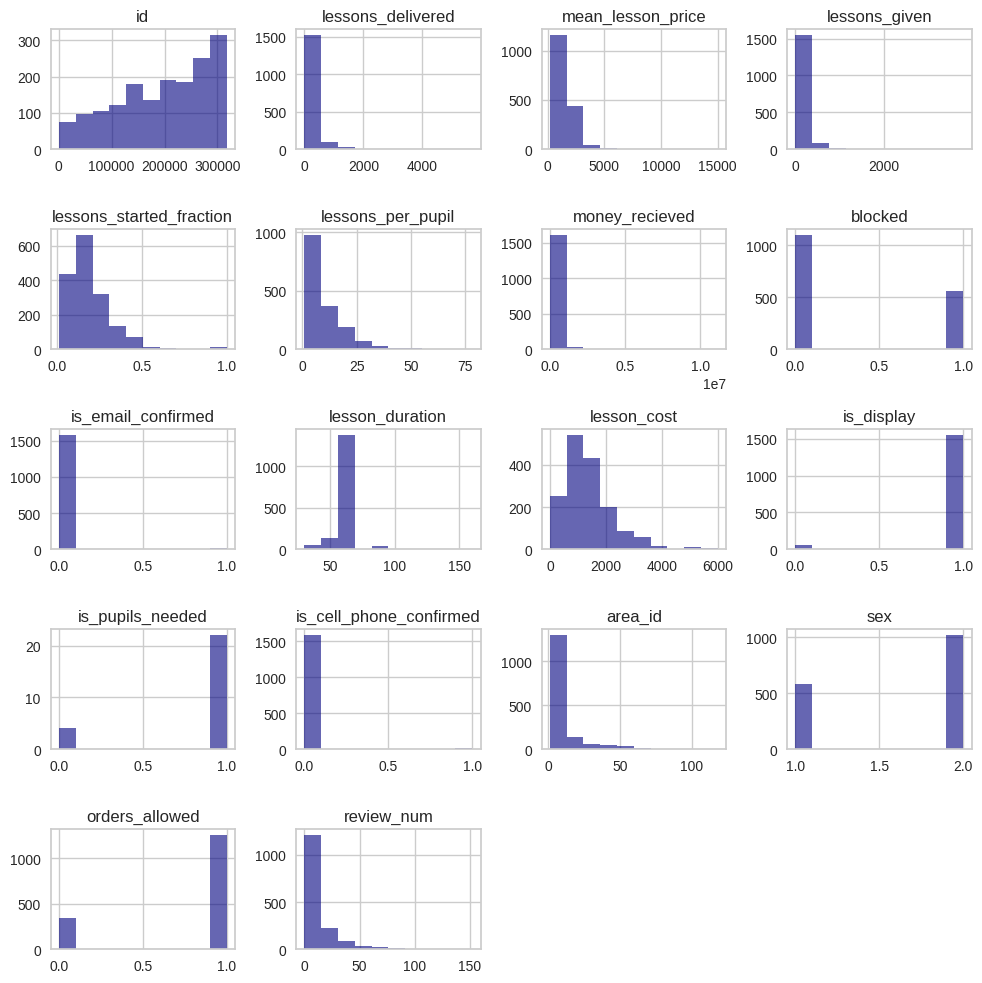

In [ ]:
df_tutors.hist(figsize=(10, 10), color='navy', alpha = 0.6)
plt.tight_layout()
plt.show()

Отдельно смотрим подробнее распределение целевого признака.

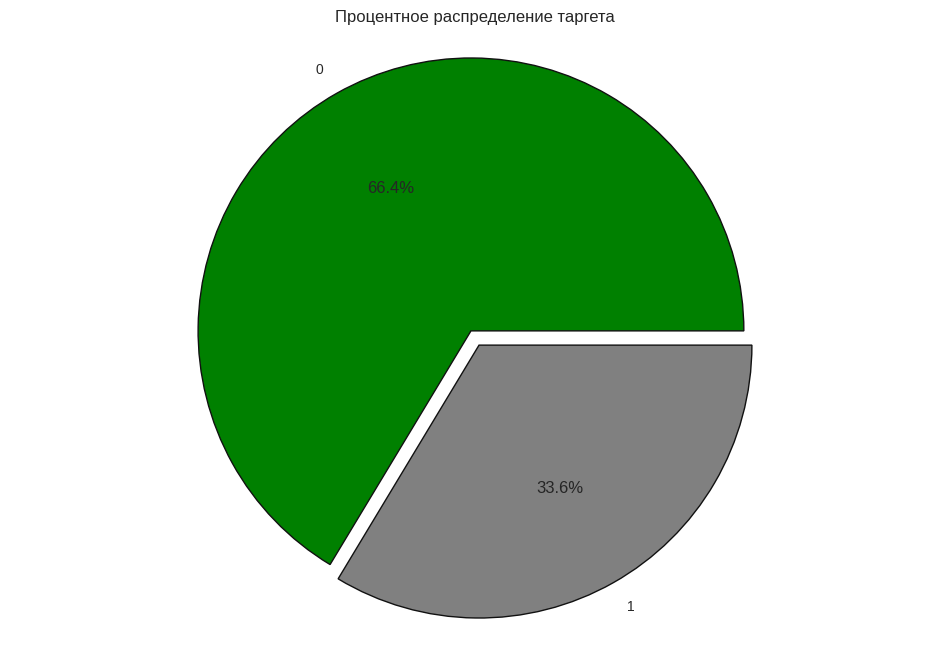

In [ ]:
counts = df_tutors['blocked'].value_counts()

explode = [0.05, 0.01] + [0] * (len(counts) - 3)
plt.figure(figsize=(12, 8))
plt.pie(
  counts.values,
  labels=counts.index,
  autopct='%1.1f%%',
  explode=explode,
  colors=['green', 'gray'] + ['C0'] * (len(counts) - 3),
  wedgeprops={'edgecolor': 'k', 'linewidth': 1},
)
plt.axis('equal')
plt.title('Процентное распределение таргета')
plt.show()

Строим два 'ящика с усами': один с ограниченными данными (без выбросов) и график с полными данными (для оценки выбросов).

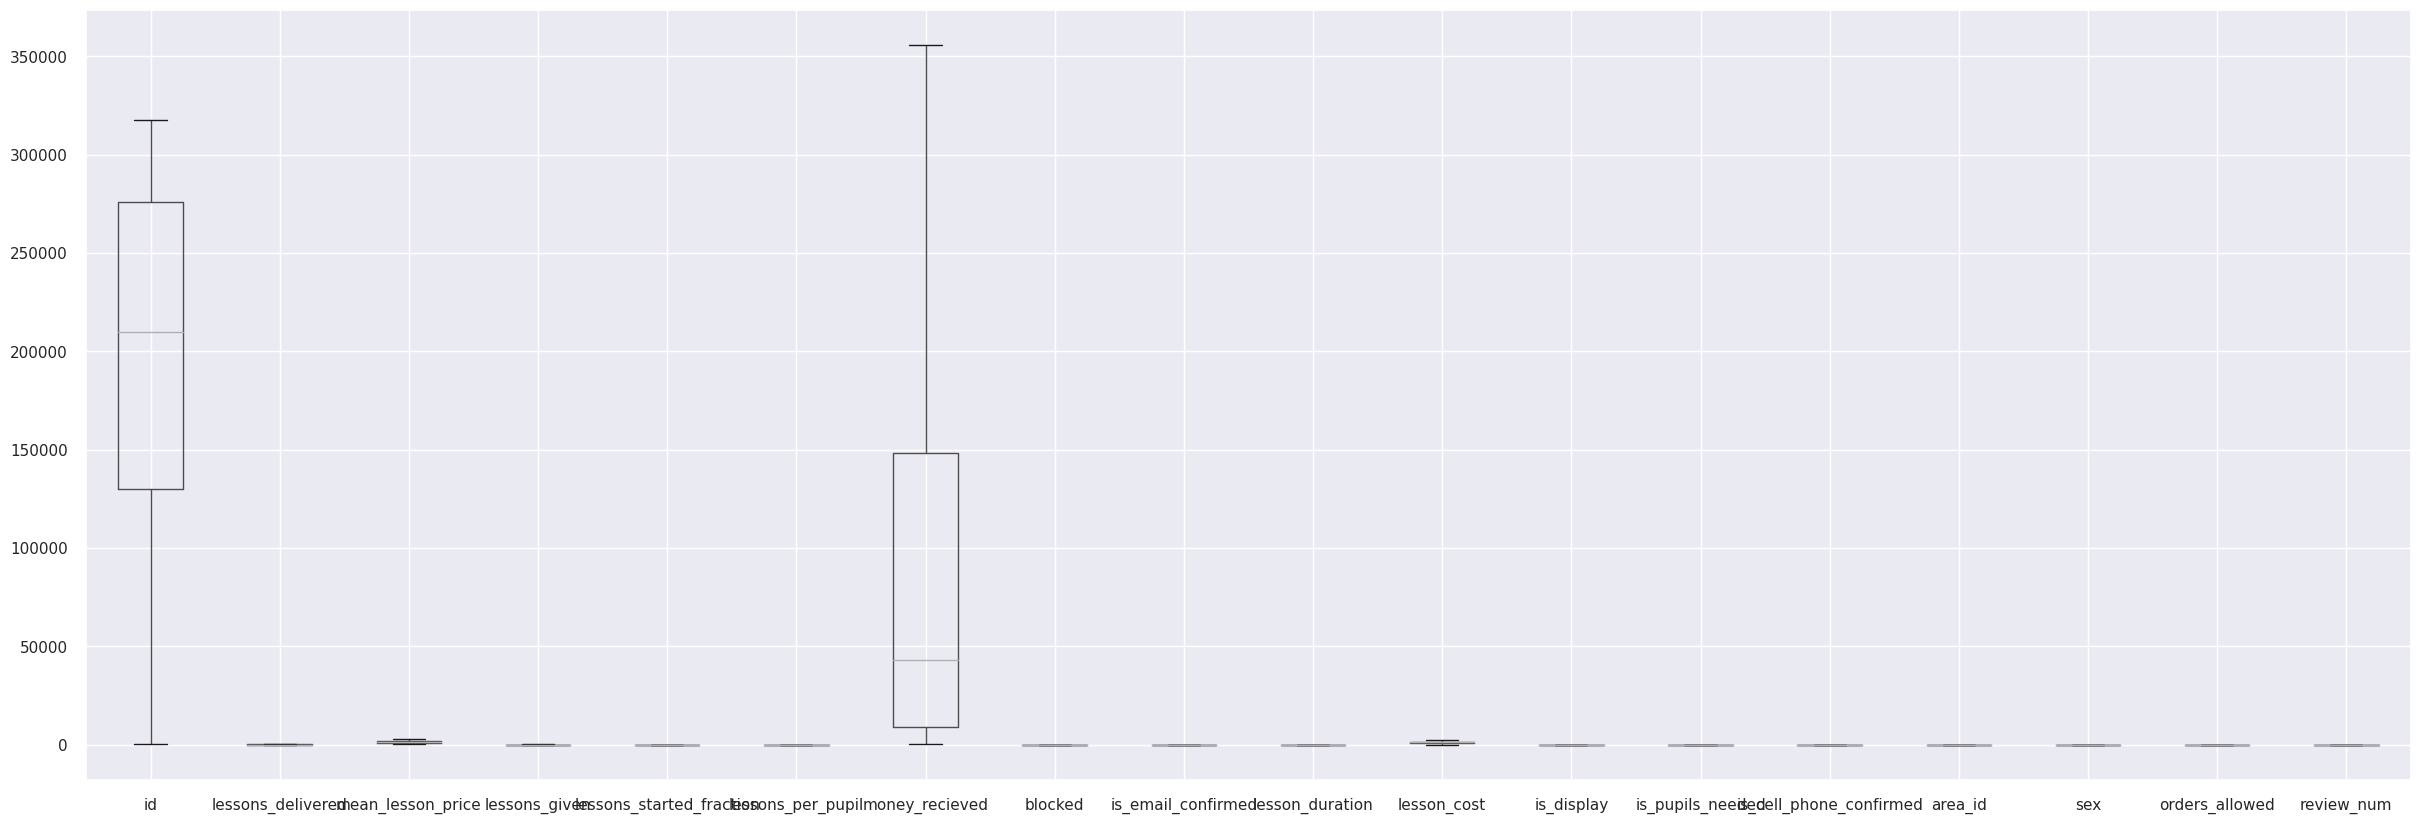

In [ ]:
sns.set(rc={'figure.figsize': (30, 10)})
df_tutors.select_dtypes(include=np.number).boxplot(sym='');

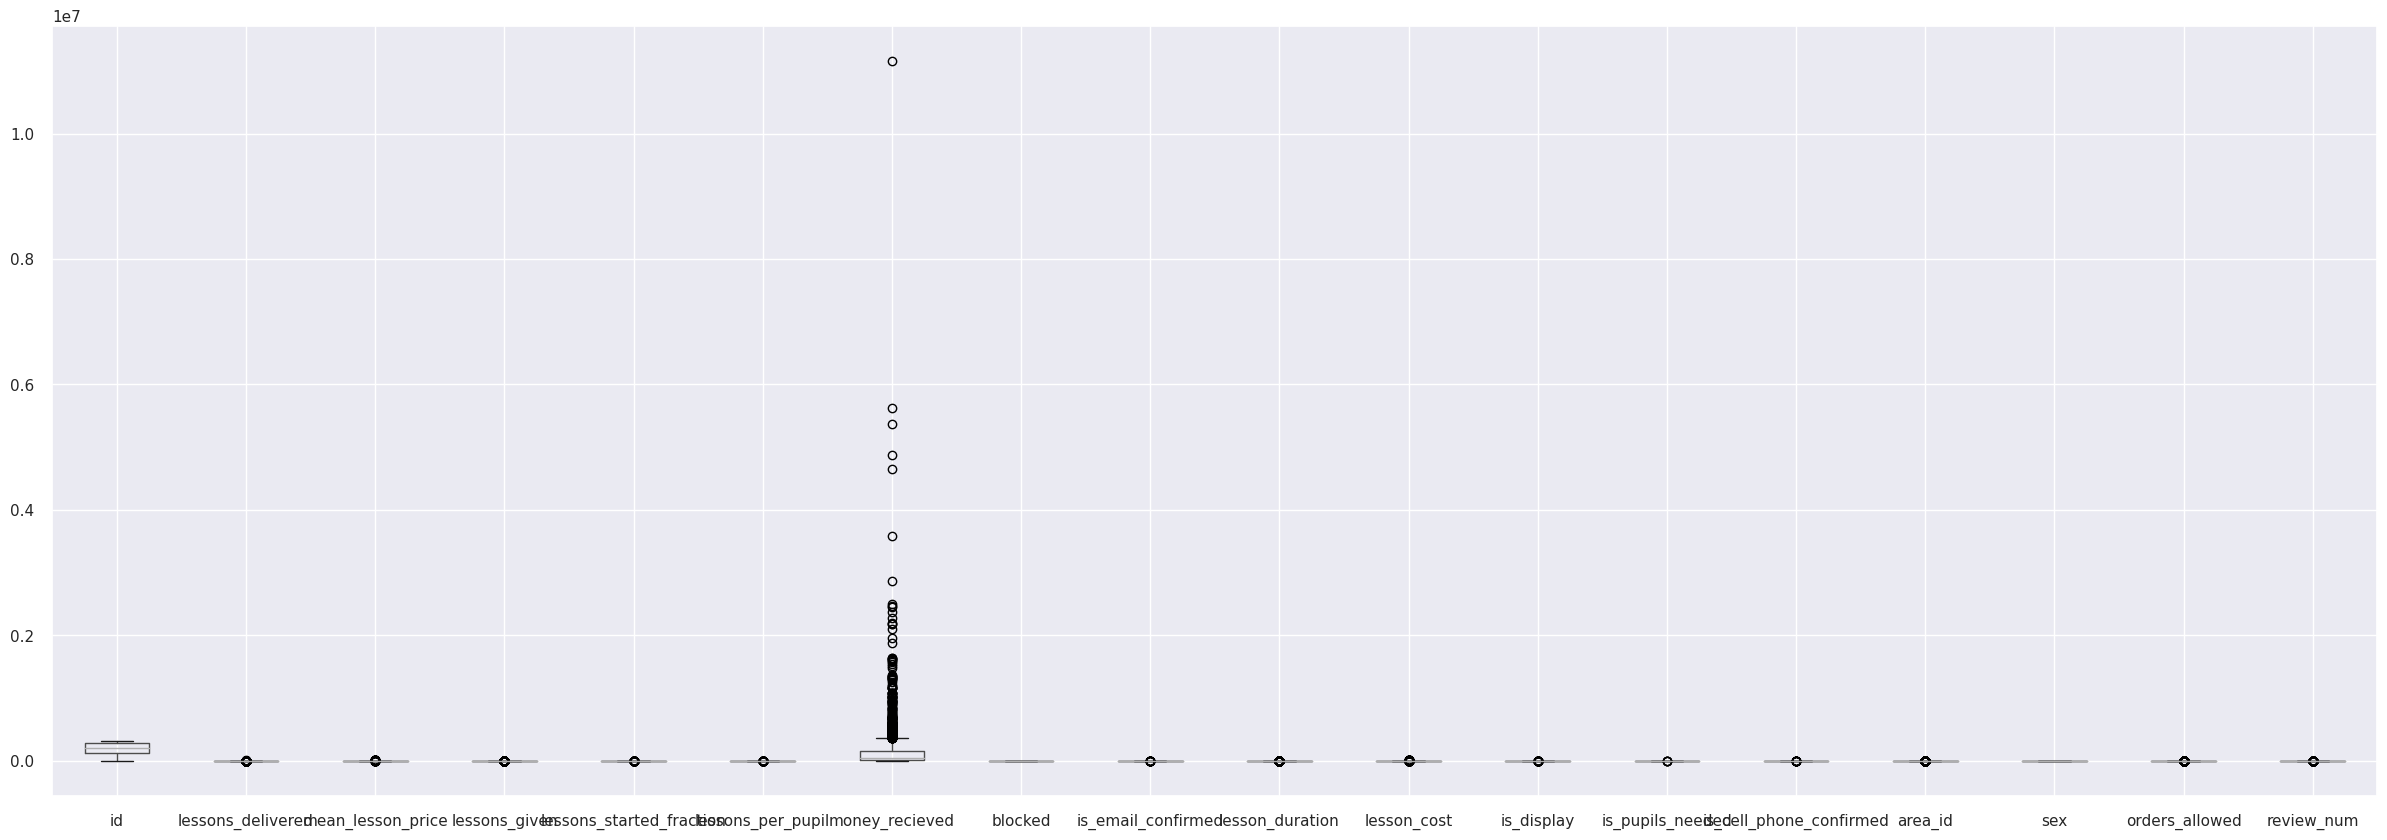

In [ ]:
sns.set(rc={'figure.figsize': (30, 10)})
df_tutors.select_dtypes(include=np.number).boxplot();

Также объединяем в единый датафрейм всю информацию об уроках.

In [ ]:
df_lessons_merged = pd.merge(
    df_lessons_course,
    df_lessons,
    left_on='id',
    right_on='lesson_course_id',
    how='inner',
)

In [ ]:
df_info(df_lessons_merged)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126437 entries, 0 to 1126436
Data columns (total 19 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   id_x               1126437 non-null  int64   
 1   client_id          1126436 non-null  float64 
 2   teacher_id         1126437 non-null  int64   
 3   order_id           1051738 non-null  float64 
 4   lesson_place       1126437 non-null  int64   
 5   lesson_price       1126437 non-null  int64   
 6   is_active          1126437 non-null  int64   
 7   lesson_duration    1126437 non-null  int64   
 8   date_updated       1126437 non-null  object  
 9   suspend_till_date  1126437 non-null  object  
 10  id_y               1126437 non-null  int32   
 11  lesson_course_id   1126437 non-null  int32   
 12  lesson_date        1126437 non-null  category
 13  time_from          1126437 non-null  category
 14  time_to            1126437 non-null  category
 15  home_task      

,id_x,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date,id_y,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
535825,913352,905358.0,201332,1962152.0,4,1000,0,60,2022-02-10 14:17:24.260,1800-01-01 00:00:00.000,2287605,913352,2022-04-11 00:00:00.000,16:45:00,17:45:00,NaN,0,NaN,NaN
906170,1265849,1138962.0,124587,2587086.0,4,1600,1,0,2023-11-02 13:11:32.330,1800-01-01 00:00:00.000,4251483,1265849,2023-11-24 00:00:00.000,09:00:00,10:00:00,NaN,1,NaN,NaN
551810,996978,963654.0,262574,2116483.0,2,700,0,60,2022-12-02 22:54:25.627,1800-01-01 00:00:00.000,2863667,996978,2022-10-12 00:00:00.000,13:00:00,14:00:00,NaN,0,NaN,NaN
626453,1003095,785875.0,240339,2127264.0,7,500,1,60,2022-08-08 12:30:52.980,1800-01-01 00:00:00.000,2635875,1003095,2022-12-30 00:00:00.000,10:00:00,11:00:00,NaN,0,500.0,NaN
244942,719589,764860.0,224381,1612100.0,4,0,1,0,2022-03-10 16:25:51.130,2022-02-13 00:00:00.000,3520073,719589,2023-04-10 00:00:00.000,11:30:00,13:00:00,NaN,0,0.0,NaN
868802,865084,874692.0,159743,1871067.0,4,1500,0,60,2021-11-27 11:10:38.447,1800-01-01 00:00:00.000,2053405,865084,2021-11-28 00:00:00.000,18:00:00,19:00:00,NaN,0,NaN,NaN
1049111,1416602,595272.0,137343,2805990.0,4,1500,1,60,2023-09-20 19:25:46.130,1800-01-01 00:00:00.000,4049240,1416602,2023-11-14 00:00:00.000,20:30:00,21:30:00,NaN,0,1500.0,NaN
714978,847483,864454.0,118772,1839520.0,4,1000,0,60,2021-10-30 22:02:49.253,1800-01-01 00:00:00.000,1972473,847483,2022-01-20 00:00:00.000,20:00:00,21:00:00,NaN,1,1000.0,NaN
591147,832825,855124.0,94573,1810317.0,1,1000,1,60,2021-10-10 20:52:53.413,1800-01-01 00:00:00.000,1904918,832825,2021-10-12 00:00:00.000,17:30:00,18:30:00,NaN,0,NaN,NaN
1055247,1099417,305511.0,221905,2309706.0,4,2000,1,60,2022-11-09 17:01:17.053,1800-01-01 00:00:00.000,3702477,1099417,2023-06-27 00:00:00.000,12:00:00,13:00:00,NaN,0,2000.0,NaN


,id_x,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,id_y,lesson_course_id,is_regular,amount_to_pay,amount_paid
count,1.126437e+06,1.126436e+06,1.126437e+06,1.051738e+06,1.126437e+06,1.126437e+06,1.126437e+06,1.126437e+06,1.126437e+06,1.126437e+06,1.126437e+06,5.645370e+05,8142.000000
mean,9.735862e+05,8.453683e+05,1.550321e+05,2.078504e+06,3.469677e+00,1.103177e+03,6.021482e-01,-3.754140e+03,2.862396e+06,9.735862e+05,1.607289e-01,1.181481e+03,1817.109433
std,2.516822e+05,2.374986e+05,7.800066e+04,4.321873e+05,1.450081e+00,2.786779e+03,4.894548e-01,2.861493e+06,7.458291e+05,2.516822e+05,3.672809e-01,4.797052e+03,972.560382
min,1.000000e+01,1.000000e+00,3.300000e+01,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-2.147484e+09,1.357970e+05,1.000000e+01,0.000000e+00,0.000000e+00,200.000000
25%,8.148110e+05,7.226450e+05,9.615800e+04,1.787783e+06,3.000000e+00,6.000000e+02,0.000000e+00,6.000000e+01,2.209517e+06,8.148110e+05,0.000000e+00,7.000000e+02,1100.000000
50%,9.729700e+05,8.701960e+05,1.542290e+05,2.080294e+06,4.000000e+00,1.000000e+03,1.000000e+00,6.000000e+01,2.836774e+06,9.729700e+05,0.000000e+00,1.000000e+03,1500.000000
75%,1.131895e+06,1.004792e+06,2.222350e+05,2.383269e+06,4.000000e+00,1.500000e+03,1.000000e+00,6.000000e+01,3.451756e+06,1.131895e+06,0.000000e+00,1.500000e+03,2000.000000
max,1.503631e+06,1.268559e+06,3.122440e+05,2.936557e+06,7.000000e+00,2.500000e+06,1.000000e+00,8.032022e+06,4.516920e+06,1.503631e+06,1.000000e+00,2.500000e+06,24000.000000



Количество явных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
id_x,0.000000
client_id,0.000000
teacher_id,0.000000
order_id,6.630000
lesson_place,0.000000
lesson_price,0.000000
is_active,0.000000
lesson_duration,0.000000
date_updated,0.000000
suspend_till_date,0.000000


## Выводы.
- Исследуемые данные и необходимые для этого библиотеки загружены;
- Данных по репетиторам в рамках машинного обучения мало, это нужно будет учесть при выборе моделей;
- В данных обнаружены пропуски, которые нужно будет обработать;
- Даты записаны как object, нужно либо изменить тип данных, либо сделать новый признак на их основе;
- Имеется дисбаланс классов в целевой переменной: отрицательных значений в 2 раза больше, чем положительных. Для устранения этого дисбаланса при обучении моделей будет использован метод SMOTE;
- Самый большой разброс в значениях и количество выбросов имеет количество заработанных репетитором денег.

# Корреляции.

Посмотрим корреляцию признаков между собой.

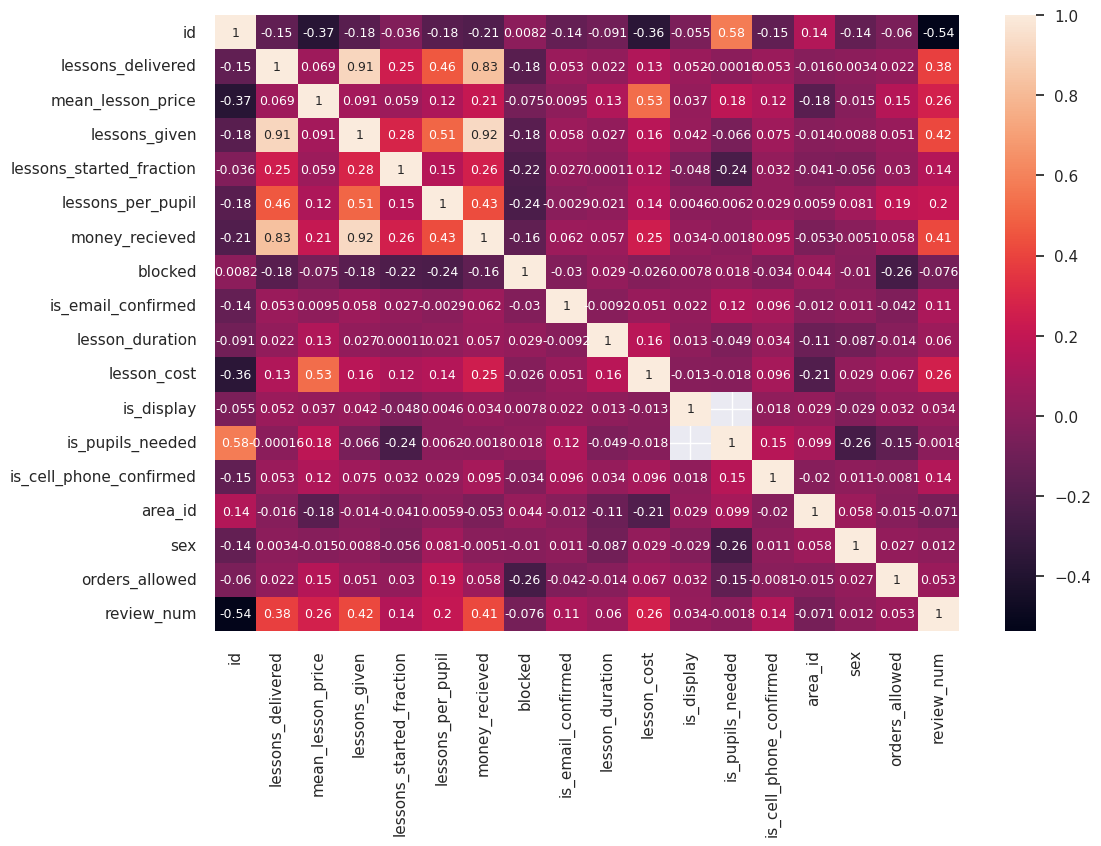

In [ ]:
numerical_columns = df_tutors.select_dtypes(include=['int64', 'float64'])

numerical_corr = numerical_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(numerical_corr, annot=True, annot_kws={'fontsize': 9})
plt.show()

## Выводы.
- Ряд признаков выглядят незначительными из-за низкого значения коэффициента корреляции с целевым. Несколько других имеют между собой очень сильную связь. Пока оставим все признаки, но учтём эти моменты.

# Определение бэйслайна, выбор моделей машинного обучения для нашей работы.

Определим отправную точку в величине метрики F1 с помощью библиотеки автоматического машинного обучения PyCaret.

In [ ]:
exp1 = setup(df_tutors, target = 'blocked', session_id=RNDM_STATE)

,Description,Value
0,Session id,42
1,Target,blocked
2,Target type,Binary
3,Original data shape,"(1656, 22)"
4,Transformed data shape,"(1656, 22)"
5,Transformed train set shape,"(1159, 22)"
6,Transformed test set shape,"(497, 22)"
7,Numeric features,17
8,Categorical features,4
9,Rows with missing values,98.4%


In [ ]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6730,0.6793,0.1949,0.5620,0.2865,0.1318,0.1665,1.0090
rf,Random Forest Classifier,0.6635,0.6961,0.0000,0.0000,0.0000,0.0000,0.0000,0.4690
qda,Quadratic Discriminant Analysis,0.6635,0.5821,0.0000,0.0000,0.0000,0.0000,0.0000,0.1360
xgboost,Extreme Gradient Boosting,0.6635,0.6493,0.0000,0.0000,0.0000,0.0000,0.0000,0.1710
dummy,Dummy Classifier,0.6635,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1290
gbc,Gradient Boosting Classifier,0.6626,0.4994,0.0000,0.0000,0.0000,-0.0017,-0.0066,0.3270
ridge,Ridge Classifier,0.6618,0.0000,0.0128,0.3000,0.0245,0.0049,0.0116,0.1480
lda,Linear Discriminant Analysis,0.6609,0.5960,0.0026,0.1000,0.0050,-0.0034,-0.0096,0.2140
et,Extra Trees Classifier,0.6575,0.6440,0.0231,0.2611,0.0408,0.0026,-0.0070,0.3450
dt,Decision Tree Classifier,0.6523,0.5000,0.0103,0.1700,0.0192,-0.0154,-0.0390,0.1320


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

## Выводы.
- Несмотря на то, что часть моделей из-за пропусков в данных даже не смогли обработать датафрейм, модель	Naive Bayes даже на таких сырых данных с помощью кроссвалидации дала значение метрики F1 0.544. Будем отталкиваться от этого значения как от минимального.
- Как уже было сказано выше, данных для классификации у нас мало, поэтому выбираем для решения нашей задачи модели попроще (относительно бустингов): уже упомянутый наивный байесовский классификатор, логистическая регрессию, решающее дерево и Random Forest.

# Обработка пропусков, удаление предположительно неважных признаков, замена типа данных для дат.

Так как рассматриваемые данные занимают относительно небольшой объём памяти, на каждом шаге при изменении существующих признаков или добавлении новых будем создавать копию данных, дабы в случае, если реализация того или иного пункта не пойдёт на пользу значению метрики, мы могли быстро вернуться к предыдущеу варианту.

In [ ]:
df_tutors_2 = df_tutors.copy()

Заменяем пропуски в информации о последнем визите на дату регистрации.

In [ ]:
df_tutors_2['last_visited'].fillna(df_tutors_2['reg_date'], inplace=True)

Удаляем ряд не влияющих на таргет параметров, параметр orders_allowed удаляем из-за возможных утечек информации. Айди репетиторов пока не трогаем: в следующем пункте на их основе будет разработан первый новый признак.

In [ ]:
df_tutors_2.drop(
    ['is_pupils_needed', 'birth_date', 'sex', 'orders_allowed'],
    axis=1,
    inplace=True,
)

Переведём даты в формат datetime.

In [ ]:
df_tutors_2['reg_date'] = pd.to_datetime(df_tutors_2['reg_date'])
df_tutors_2['teaching_start_date'] = pd.to_datetime(df_tutors_2['teaching_start_date'])
df_tutors_2['last_visited'] = pd.to_datetime(df_tutors_2['last_visited'])

Проверяем, что получилось.

In [ ]:
df_info(df_tutors_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        1656 non-null   int64         
 1   lessons_delivered         1656 non-null   float64       
 2   mean_lesson_price         1656 non-null   float64       
 3   lessons_given             1656 non-null   float64       
 4   lessons_started_fraction  1656 non-null   float64       
 5   lessons_per_pupil         1656 non-null   float64       
 6   money_recieved            1656 non-null   float64       
 7   blocked                   1656 non-null   int64         
 8   reg_date                  1602 non-null   datetime64[ns]
 9   teaching_start_date       1602 non-null   datetime64[ns]
 10  is_email_confirmed        1602 non-null   float64       
 11  lesson_duration           1602 non-null   float64       
 12  lesson_cost         

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_cell_phone_confirmed,area_id,review_num
1463,284135,4.0,766.666667,3.0,0.095238,1.500000,2300.0,1,2023-01-20 21:17:14.710,2020-09-01,0.0,60.0,2000.0,1.0,2023-01-20 21:17:14.710,0.0,1.0,0.0
413,236304,167.0,1061.111111,162.0,0.333333,13.500000,171900.0,0,2021-07-27 10:50:20.880,2016-09-01,0.0,60.0,1000.0,1.0,2022-10-24 11:05:49.163,0.0,1.0,6.0
838,305346,38.0,908.571429,35.0,0.357143,7.000000,31800.0,0,2023-09-06 08:54:24.403,2016-09-01,0.0,60.0,1000.0,1.0,2023-09-06 08:54:24.403,0.0,17.0,0.0
490,224886,138.0,1250.000000,48.0,0.181818,12.000000,60000.0,1,2021-02-04 20:47:09.807,2020-09-01,0.0,60.0,2000.0,1.0,2022-08-10 15:08:02.127,0.0,1.0,7.0
1370,316562,276.0,600.000000,4.0,0.105263,2.000000,2400.0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1540,277393,3.0,500.000000,2.0,0.285714,1.000000,1000.0,1,2022-10-29 18:28:08.097,2022-09-01,0.0,60.0,700.0,1.0,2022-10-29 18:28:08.097,0.0,1.0,0.0
1624,317478,1.0,700.000000,1.0,0.333333,1.000000,700.0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
438,243138,40.0,1051.282051,39.0,0.200000,13.000000,41000.0,0,2021-09-19 17:28:25.710,2021-09-01,0.0,60.0,0.0,1.0,2022-10-11 20:17:29.770,0.0,1.0,3.0
720,62688,159.0,1300.000000,33.0,0.114286,8.250000,42900.0,1,2014-02-20 01:15:41.000,2011-09-01,0.0,60.0,400.0,1.0,2022-10-15 21:17:44.723,0.0,13.0,19.0
1314,305953,79.0,847.058824,17.0,0.200000,2.428571,14400.0,0,2023-09-10 13:26:05.373,2003-09-01,0.0,60.0,0.0,1.0,2023-09-10 13:26:05.373,0.0,14.0,2.0


,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_cell_phone_confirmed,area_id,review_num
count,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1.656000e+03,1656.000000,1602,1602,1602.000000,1602.000000,1602.000000,1602.000000,1602,1602.000000,1602.000000,1602.000000
mean,195700.558575,177.651570,1509.636125,104.064614,0.194887,9.872112,1.750237e+05,0.336353,2019-08-04 21:04:03.592272896,2012-10-24 16:12:35.056179712,0.013733,59.066792,1293.895131,0.967541,2022-10-09 12:35:52.931820544,0.009988,7.368290,11.209114
min,458.000000,1.000000,200.000000,1.000000,0.009901,1.000000,2.000000e+02,0.000000,2008-02-16 12:29:21,1978-09-01 00:00:00,0.000000,30.000000,0.000000,0.000000,2013-02-19 18:16:50,0.000000,1.000000,0.000000
25%,130185.500000,12.000000,994.880952,8.000000,0.105263,3.000000,9.000000e+03,0.000000,2017-09-08 00:55:04.500000,2008-09-01 00:00:00,0.000000,60.000000,800.000000,1.000000,2022-09-20 17:21:27.832999936,0.000000,1.000000,1.000000
50%,210036.500000,54.000000,1350.308642,30.000000,0.166667,7.094017,4.310000e+04,0.000000,2020-08-11 14:57:54.223000064,2015-09-01 00:00:00,0.000000,60.000000,1200.000000,1.000000,2022-10-19 16:35:16.600000,0.000000,1.000000,5.000000
75%,276014.500000,207.500000,1852.012502,103.000000,0.250000,13.500000,1.483500e+05,1.000000,2022-09-04 21:34:07.577500160,2018-09-01 00:00:00,0.000000,60.000000,1500.000000,1.000000,2022-10-24 16:12:01.068250112,0.000000,3.000000,15.000000
max,317531.000000,5690.000000,15000.000000,3788.000000,1.000000,78.166667,1.116220e+07,1.000000,2023-11-05 22:33:11.540000,2023-09-01 00:00:00,1.000000,160.000000,6000.000000,1.000000,2023-11-05 22:33:11.540000,1.000000,118.000000,152.000000
std,87667.530193,336.451272,908.722960,217.635955,0.135023,9.601426,4.850086e+05,0.472604,NaN,NaN,0.116416,8.396776,872.773166,0.177272,NaN,0.099468,14.442345,16.842826



Количество явных дубликатов в датафрейме: 0.

Процент пропусков по столбцам:


,0
id,0.000000
lessons_delivered,0.000000
mean_lesson_price,0.000000
lessons_given,0.000000
lessons_started_fraction,0.000000
lessons_per_pupil,0.000000
money_recieved,0.000000
blocked,0.000000
reg_date,3.260000
teaching_start_date,3.260000


Оставшиеся в датафрейме 3 процента пропусков удаляем.

In [ ]:
df_tutors_2.dropna(inplace=True)

## Выводы.
- Данные подготовлены для применения в машинном обучении, но нам осталось осталось разобраться с датами, потому что не все модели умеют работать с типом данных datetime. Далее на основе дат будут сгенерированы новые признаки.

# Новые признаки, связанные с ценами у репетиторов.

Но, прежде чем разбираться с датами, обработаем айди репетиторов. Сами по себе они для нас не представляют интерес, потому что никак не связаны с решаемым вопросом. Однако до этого момента я их не удалял, т. к. айди могут помочь нам в создании новых признаков. Первый будет равнен единице, если у репетитора в анкете указана одна цена за урок, а в реальности она была другая. Второй признак будет равен единице, если у репетитора в расписании разные цены.

In [ ]:
df_tutors_3 = df_tutors_2.copy()

In [ ]:
# Cоздаём список, куда будут помещеный интересующие нас айди потенциальных
# неэффективных репетиторов

wrong_prices_teachers_ids  = []

# Проходим по уникальным айди в df_tutors_3
for tutor_id in df_tutors_3['id'].unique():
    tutor_lesson_cost = df_tutors_3[df_tutors_3['id'] == tutor_id][
        'lesson_cost'
    ].values[0]

    # Проверяем, существует ли айди в df_lessons_merged и получаем amount_to_pay
    if tutor_id in df_lessons_merged['teacher_id'].unique():
        lesson_amount_to_pay = df_lessons_merged[
            df_lessons_merged['teacher_id'] == tutor_id
        ]['lesson_price'].values[0]

        # Сравниваем lesson_cost с amount_to_pay
        if tutor_lesson_cost != lesson_amount_to_pay:
            wrong_prices_teachers_ids.append(tutor_id)

Заполняем значение нового признака для всей таблицы.

In [ ]:
df_tutors_3['wrong_price'] = df_tutors_3['id'].apply(
    lambda x: 1 if x in wrong_prices_teachers_ids else 0
)

In [ ]:
# Аналогично предыдущему создаём список
different_prices_teachers_ids = []

# Проходимся по айдишникам в df_lessons_merged
for teacher_id in df_lessons_merged["teacher_id"].unique():
    lesson_prices = df_lessons_merged[df_lessons_merged["teacher_id"] == teacher_id][
        "lesson_price"
    ]

    # Если значения lesson_price неодинаковы, добавляем teacher_id в список
    if len(lesson_prices.unique()) > 1:
        different_prices_teachers_ids.append(teacher_id)

И тоже заполняем признак.

In [ ]:
df_tutors_3['different_prices'] = df_tutors_3['id'].apply(
    lambda x: 1 if x in different_prices_teachers_ids else 0
)

Теперь удаляем сами айди.

In [ ]:
df_tutors_3.drop('id',
    axis=1,
    inplace=True,
)

# Обработка дат.

Идея следующая: выбрать датой выгрузки условную дату 1 января 2024. После этого вычитаем из этой даты дату регистрации и добавляем как признак 'дней зарегистрирован'\ дату первого урока и добавляем как признак 'дней работает'\ дату последнего захода на сайт и добавляем как признак 'дней оффлайн'.

In [ ]:
df_tutors_4 = df_tutors_3.copy()

In [ ]:
download_date = pd.Timestamp('2024-01-01')

# Вычисление разницы в днях
df_tutors_4['days_registered'] = (download_date - df_tutors_4['reg_date']).dt.days
df_tutors_4['days_working'] = (download_date - df_tutors_4['teaching_start_date']).dt.days
df_tutors_4['days_offline'] = (download_date - df_tutors_4['last_visited']).dt.days

df_tutors_4 = df_tutors_4.drop(columns=['reg_date', 'teaching_start_date', 'last_visited'])

In [ ]:
train_test_models(df_tutors_4, 'blocked')

{'Наивный байесовский классификатор': 0.6926163025240648,
 'Логистическая регрессия': 0.7044795009113429,
 'Решающее дерево': 0.7097436379203007,
 'Random Forest': 0.7833091087473001}

## Выводы.
- На основе дат созданы признаки, понятные всем моделям.
- При кросс-валидации на тестовых данных вперёд успешно вырвалась модель RandomForest. Будем следить дальше за ней, как за самой перспективной, остальные модели оставим для сравнения результатов.

# Обработка населённых пунктов.

Разделим репетиторов из Москвы и остальных городов. Для этого посмотрим значения айди населённых пунктов.

In [ ]:
df_tutors_5 = df_tutors_4.copy()

Посмотрим, какие значения есть у идентификаторов населённых пунктов, и каких населённых пунктов сколько.

In [ ]:
df_tutors_5['area_id'].value_counts()

area_id
1.0     961
2.0     211
14.0     34
3.0      31
27.0     23
       ... 
61.0      1
91.0      1
46.0      1
57.0      1
34.0      1
Name: count, Length: 66, dtype: int64

Логично, что репетиторов из Москвы в данных представлено больше всего, поэтому айди 1.0 обозначает столицу. Добавим новый признак 'from_moscow', который у московских репетиторов будет равен единице, а у всех остальных нулю.

In [ ]:
df_tutors_5['from_moscow'] = df_tutors_5['area_id'].apply(
    lambda x: 1 if x == 1.0 else 0
)

Проогоним модели, посмотрим, есть ли положительный результат.

In [ ]:
train_test_models(df_tutors_5, 'blocked')

{'Наивный байесовский классификатор': 0.6960304381341409,
 'Логистическая регрессия': 0.709345658987026,
 'Решающее дерево': 0.6908205575102331,
 'Random Forest': 0.788936013018079}

## Выводы.
- Разделение на репетиторов на московских и всех остальных дало небольшой (на тысячные доли), но всё же рост максимального значения метрики. Оставляем новый признак.

# Выявление репетиторов с подозрительно низкой ценой урока.

Создадим новый признак с подозрительно низкой ценой за один урок: у репетиторов из Москвы этот признак будет принимать единицу, если цена меньше 700 рублей, у репетиторов из регионов - если цена меньше 500 рублей. Остальным будет ставиться 0.

In [ ]:
df_tutors_6 = df_tutors_5.copy()

In [ ]:
df_tutors_6['too_low_price'] = df_tutors_6.apply(
    lambda x: 1
    if (x['from_moscow'] == 1 and x['lesson_cost'] < 700)
    or (x['from_moscow'] == 0 and x['lesson_cost'] < 500)
    else 0,
    axis=1,
)

Посмотрим, сколько каких репетиторов у нас в итоге было насчитано.

In [ ]:
df_tutors_6['too_low_price'].value_counts()

too_low_price
0    1371
1     231
Name: count, dtype: int64

Прогоним модели с новым признаком.

In [ ]:
train_test_models(df_tutors_6, 'blocked')

{'Наивный байесовский классификатор': 0.6987903938277972,
 'Логистическая регрессия': 0.713088737138128,
 'Решающее дерево': 0.6876971667914523,
 'Random Forest': 0.7913879222430598}

## Выводы.
- И снова наибольшее значение метрики подросло, этот признак тоже оставляем.
- На тренировочных данных с помощью модели RandomForest удалось достигнуть неплохо значения метрики F1 0.791. Посмотрим, насколько хорошо она проявит себя на тестовых данных.

# Машинное обучение на тестовой выборке.

Обучаемся на тренировочной выборке, подвергнутой SMOTE, делаем предсказание на тестовой, считаем значение метрики. Гиперпараметры для модели были подобраны с помощью RandomSearch в отдельном черновике, здесь, к сожалению, с этим же random_state поиск выдаёт гиперпараметры, дающие в итоге ощутимо худшее значение метрики.

In [ ]:
X = df_tutors_6.drop(columns=['blocked'])
y = df_tutors_6['blocked']

numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=RNDM_STATE, stratify=y
    )
smote = SMOTE(sampling_strategy='auto',  random_state=RNDM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(random_state=RNDM_STATE,
                                  n_estimators = 1500,
                                  min_samples_split = 5,
                                  min_samples_leaf = 5,
                                  max_depth= 120,
                                  bootstrap = True)

rf_model.fit(X_train_resampled, y_train_resampled)

y_pred = rf_model.predict(X_test)

f1 = f1_score(y_test, y_pred)

f'Величина метрики F1 на тестовых данных: {f1}'

'Величина метрики F1 на тестовых данных: 0.6443514644351465'

Теперь смотрим матрицу ошибок.

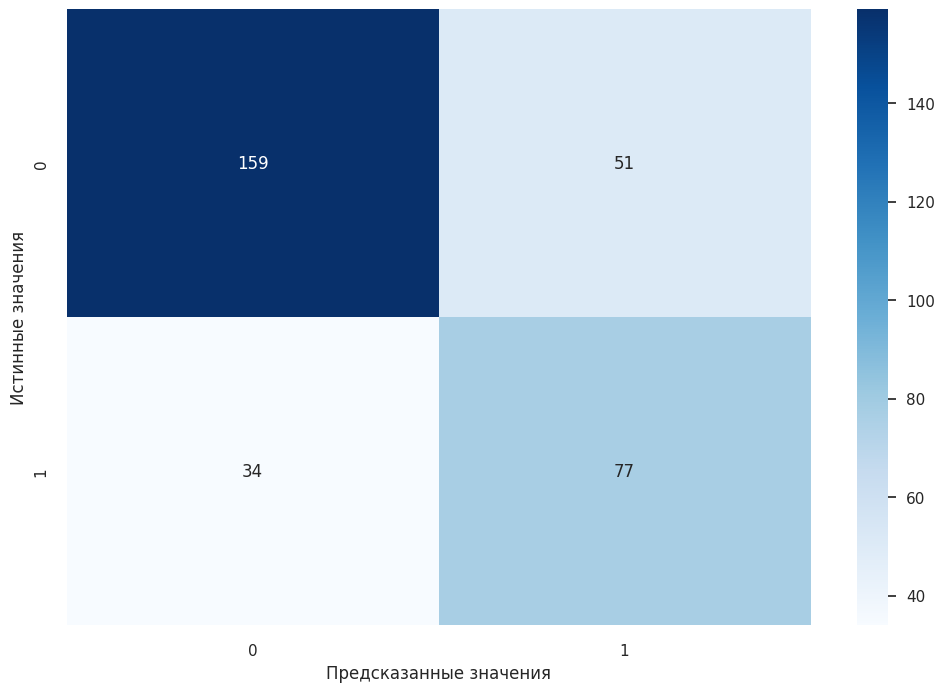

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True,  fmt='d', cmap='Blues')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')

plt.show()

## Выводы.
- Значение метрики упало относительно тренировочной выборки, на тестовых данных оно составляет 0.644.
- Модель лучше распознаёт нолики, чем единички. Можно попытаться немного улучшить её в этом направлении.

# Улучшение итоговой модели.

Смотрим, какие признаки в итоге оказались важными для модели, а какие нет.

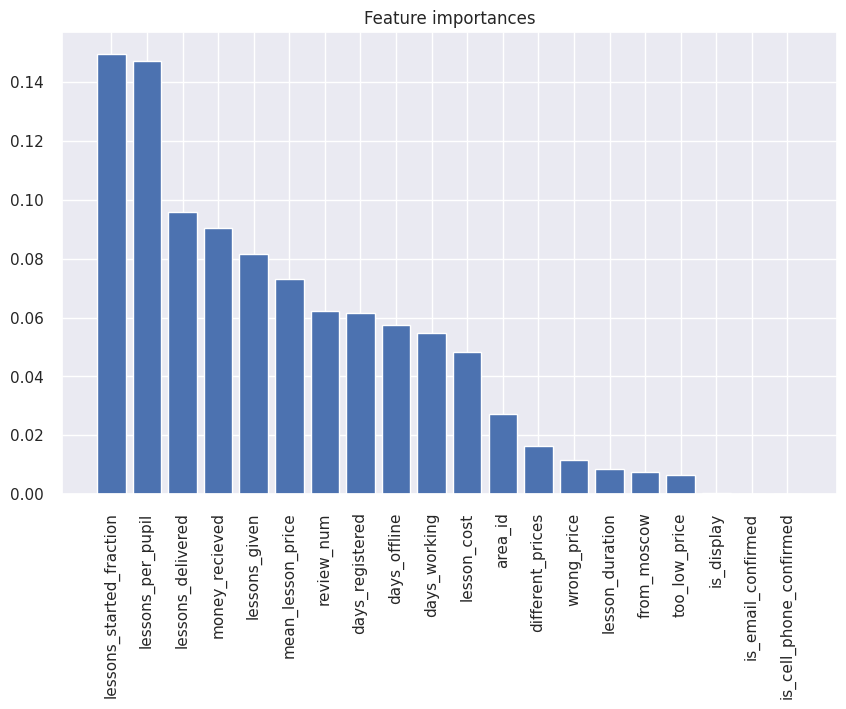

In [ ]:
importance = rf_model.feature_importances_

feature_names = X_train.columns
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importance[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.show()

Попробуем удалить пару признаков, помеченных моделью, как неважные.

In [ ]:
df_tutors_7 = df_tutors_6.copy()

df_tutors_7.drop(['is_cell_phone_confirmed', 'is_display'],
    axis=1,
    inplace=True,
)

Повторно обучим модель с теми же параметрами, но на данных без удалённых признаков, посмотрим новое значение метрики.

In [ ]:
X = df_tutors_7.drop(columns=['blocked'])
y = df_tutors_7['blocked']

numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=RNDM_STATE, stratify=y
    )
smote = SMOTE(sampling_strategy='auto',  random_state=RNDM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(random_state=RNDM_STATE,
                                  n_estimators = 1500,
                                  min_samples_split = 5,
                                  min_samples_leaf = 5,
                                  max_depth= 120,
                                  bootstrap = True)

rf_model.fit(X_train_resampled, y_train_resampled)

y_pred = rf_model.predict(X_test)

f1 = f1_score(y_test, y_pred)

f'Величина метрики F1 на тестовых данных: {f1}'

'Величина метрики F1 на тестовых данных: 0.6583333333333333'

А теперь посмотрим, как сказалось изменение значения метрики на матрице ошибок.

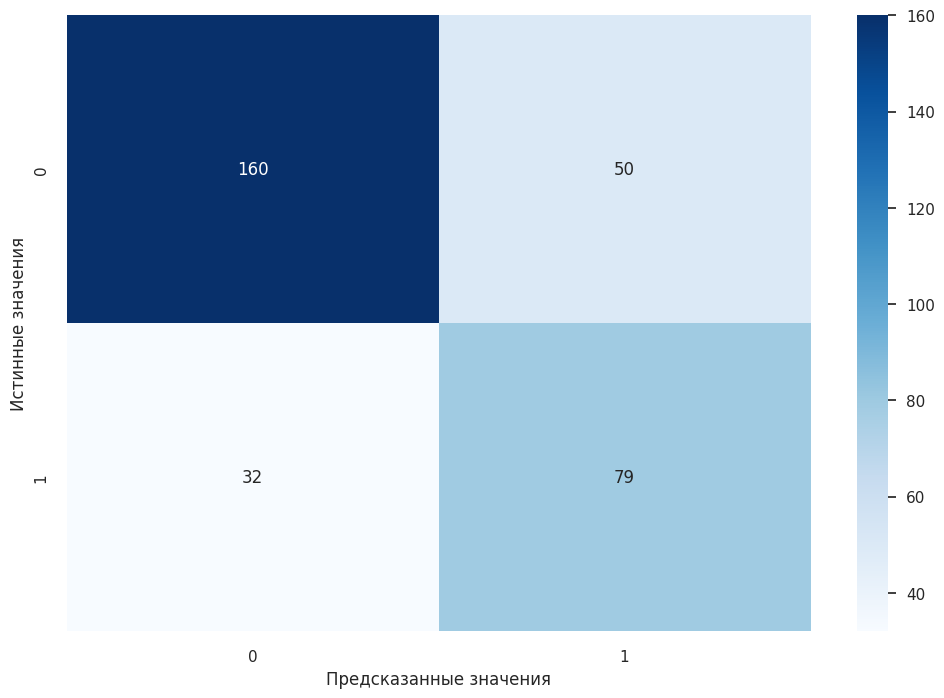

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True,  fmt='d', cmap='Blues')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')

plt.show()

## Выводы.
- После удаления признаков, не влияющих на таргет, величина метрики F1 увеличилась до 0.658.
- Согласно новой матрице ошибок, модель верно определила на одного больше эффективного репетитора и на двух больше неэффективных.

# Выводы по работе.
- Данные были загружены, изучены и подготовлены к машинному обучению.
- Были построены графики.
- Рассмотрены корреляции признаков.
- Был разработан ряд синтетических признаков.
- Наилучший результат на тренировочных данных (величина метрики F1 0.791) удалось достигнуть с помощью модели RandomForest, она и была выбрана для предсказания на тестовой подвыборке.
- Итоговое значение метрики на тестовых данных 0.658.
- Итоговый набор входящих признаков: признаки из исходного датасета lessons_delivered, mean_lesson_price, lessons_given, lessons_started_fraction, lessons_per_pupil,money_recieved, is_email_confirmed, lesson_duration, lesson_cost, area_id, review_num и синтетические признаки wrong_price, different_prices, days_registered, days_working, days_offline, from_moscow,  too_low_price.
